<a id="data-source"></a>
## Exploratory Data Analysis - Employment Growth and Office Real Estate Values  

Judy Chen

Data Dictioanary:<br>
https://github.com/jchen9619/Employment-Growth-and-Office-Property-Values/blob/main/Data%20Dictionary%20-%20Preprocessed%20Dataset.ipynb

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('fivethirtyeight') 

### Feature Variables: Bureau of Labor Statistics (BLS) Data
---
#### Reading in Raw Data
Create a list of file names to import: 

In [2]:
path_BLS = '/Users/chenmouse/Desktop/GA-Folder/JudyChenGA0316/JC0316/GA Final Project/BLS/To Use'
files_BLS = os.listdir(path_BLS)
files_BLS_xlsx = [fb for fb in files_BLS if fb[-4:] == 'xlsx']
path_BLS_xlsx=["./BLS/To Use/"+ f2 for f2 in files_BLS_xlsx]

**Combine Datasets from May 2020 and May 2010:**

In [3]:
BLS_M2020 =pd.read_excel(path_BLS_xlsx[0])
BLS_M2010 =pd.read_excel(path_BLS_xlsx[1])

In [4]:
BLS_M2020['Year']=2020
BLS_M2010['Year']=2010

Match column names for *BLS_M2010* to *BLS_M2020*:

In [5]:
BLS_M2010.rename(columns={'AREA_NAME':'AREA_TITLE', 'GROUP':'O_GROUP','LOC QUOTIENT':'LOC_QUOTIENT'}, inplace=True)

Count the number of <u>AREA_TITLE</u> in the two datasets respectively:

In [6]:
print("Number of MSA - 2010: " + str(len(pd.unique(BLS_M2010['AREA_TITLE']))))
print("Number of MSA - 2020: "+str(len(pd.unique(BLS_M2020['AREA_TITLE']))))

Number of MSA - 2010: 11
Number of MSA - 2020: 396


Since *BLS_M2010* clearly has fewer MSAs, we will subset *BLS_M2020* to only include the MSAs in *BLS_M2010*.

Create a list for values of <u>PRIM_STATE</u> in <u>BLS_M2010</u>:

In [7]:
M2010States=list(pd.unique(BLS_M2010['PRIM_STATE']))

Subset *BLS_M2020* to only keep rows where <u>PRIM STATE</u> is in <u>M2010States</u>:

In [8]:
mask = BLS_M2020.PRIM_STATE.isin(M2010States)

In [9]:
BLS_M2020_10States=BLS_M2020[mask]

Create lists of <u>AREA TITLE</u> in *BLS_M2010* and *BLS_M2020_10States*:

In [10]:
MSA_M2010=list(pd.unique(BLS_M2010['AREA_TITLE']))
MSA_M2020=list(pd.unique(BLS_M2020_10States['AREA_TITLE']))

Shorten the names in MSA_M2010:

In [11]:
MSA_M2010_short = ['Los Angeles','San Francisco',
                   'Washington','Miami','Chicago','Boston','Detroit','New York','Philadelphia','Dallas','Seattle']

Only keep rows in *BLS_M2020_10States* where the words before "-" under <u>AREA_TITLE</u> matches an element of MSA_M2020_short

In [12]:
oldlist=list(BLS_M2020_10States.AREA_TITLE)

In [13]:
MSA2020BeforeDash=list(BLS_M2020_10States['AREA_TITLE'].str.split('-').str[0])
BLS_M2020_10States['AREA_TITLE'] = BLS_M2020_10States['AREA_TITLE'].replace(oldlist,MSA2020BeforeDash)

In [14]:
mask2=BLS_M2020_10States['AREA_TITLE'].isin(MSA_M2010_short)

In [15]:
BLS_M2020_11MSA=BLS_M2020_10States[mask2]

Replace <u>AREA TITLE</u> in *BLS_M2010* with elements of MSA_M2010_short:

In [16]:
oldlist2010=list(BLS_M2010.AREA_TITLE)
MSA2010BeforeDash=list(BLS_M2010['AREA_TITLE'].str.split('-').str[0])
BLS_M2010['AREA_TITLE'] = BLS_M2010['AREA_TITLE'].replace(oldlist2010,MSA2010BeforeDash)
BLS_M2010['AREA_TITLE'].value_counts()

New York         756
Los Angeles      751
Chicago          747
Philadelphia     732
Dallas           727
Boston           721
Washington       713
Seattle          710
San Francisco    709
Miami            696
Detroit          678
Name: AREA_TITLE, dtype: int64

Combine *BLS_M2020_11MSA* and *BLS_2010*: 

In [17]:
BLS_df=pd.concat([BLS_M2020_11MSA,BLS_M2010])

The relevant columns are <u>AREA_TITLE</u>, <u>prim_state</u>, <u>OCC_TITLE</u>, <u>O_GROUP</u>, <u>TOT_EMP</u>, <u>JOBS_1000</u>, <u>LOC_QUOTIENT</u>, <u>A_MEAN</u>, <u>A_MEDIAN</u> and  <u>H_MEDIAN</u>. <br> We will drop the rest and save the output to a new dataframe:

In [18]:
BLS_df_2 = BLS_df[['Year','AREA_TITLE', 'PRIM_STATE','OCC_TITLE', 'O_GROUP','TOT_EMP','JOBS_1000',
                       'LOC_QUOTIENT','A_MEAN','A_MEDIAN','H_MEDIAN']]

Only keep rows where <u>O_GROUP</u> is "major", to retrieve occupation types at the broadest level:

In [19]:
BLS_df_3 = BLS_df_2[BLS_df_2['O_GROUP']=="major"]

Only keep rows where <u>OCC_TITLE</u> is not "All Occupations":

In [20]:
BLS_df_4 = BLS_df_3[BLS_df_3['OCC_TITLE']!="All Occupations"]

<u>TOT_EMP</u>, <u>JOBS_1000</u>, <u>LOC_QUOTIENT</u>, <u>A_MEAN</u>, <u>A_MEDIAN</u>, <u>H_MEDIAN</u> need to be converted to float. We will start by dropping rows where values for these columns are not numerical:

In [21]:
Check_num_list = ['TOT_EMP','JOBS_1000','LOC_QUOTIENT','A_MEAN','A_MEDIAN','H_MEDIAN']
for i in Check_num_list:
    BLS_df_4 = BLS_df_4[pd.to_numeric(BLS_df_4[i],errors='coerce').notna()]
    BLS_df_4[i]=BLS_df_4[i].astype('float')

Sort combined data *BLS_df_4* by MSA (<u>AREA_TITLE</u>) and Job Type (<u>OCC_TITLE</u>)

In [22]:
BLS_df_4.sort_values(["AREA_TITLE","OCC_TITLE"], axis=0, inplace=True)

Subset *BLS_df_4* to only occupations that require office space:

In [23]:
OCC_OfficeOnly = BLS_df_4['OCC_TITLE'].unique().tolist()

Remove "Farming, Fishing, and Forestry Occupations" as it is not an occupation that requires office space:

In [24]:
OCC_OfficeOnly.remove('Farming, Fishing, and Forestry Occupations')

In [25]:
BLS_df_4= BLS_df_4[BLS_df_4['OCC_TITLE'].isin(OCC_OfficeOnly)].reset_index(drop=True)

In [26]:
BLS_df_4['OCC_TITLE'].value_counts()

Transportation and Material Moving Occupations                22
Personal Care and Service Occupations                         22
Arts, Design, Entertainment, Sports, and Media Occupations    22
Installation, Maintenance, and Repair Occupations             22
Construction and Extraction Occupations                       22
Legal Occupations                                             22
Architecture and Engineering Occupations                      22
Production Occupations                                        22
Community and Social Service Occupations                      22
Healthcare Support Occupations                                22
Food Preparation and Serving Related Occupations              22
Healthcare Practitioners and Technical Occupations            22
Sales and Related Occupations                                 22
Protective Service Occupations                                22
Building and Grounds Cleaning and Maintenance Occupations     22
Office and Administrative

Examine the occupations with single numbers of entries: "Management Occupations", "Education, Training, and Library Occupations" and "Educational Instruction and Library Occupations":

Since "Education, Training, and Library Occupations" and "Educational Instruction and Library Occupations" are the same category with different naming conventions between 2010 and 2020, We will unify the two as "Education, Training, and Library Occupations". </br>

In [27]:
BLS_df_4.replace('Educational Instruction and Library Occupations', 'Education, Training, and Library Occupations', inplace=True)

"Management Occupations" is missing 2020 data for Seattle, so we will drop index 406:

In [28]:
BLS_df_4[BLS_df_4['OCC_TITLE']=="Management Occupations"]

,Year,AREA_TITLE,PRIM_STATE,OCC_TITLE,O_GROUP,TOT_EMP,JOBS_1000,LOC_QUOTIENT,A_MEAN,A_MEDIAN,H_MEDIAN
28,2020,Boston,MA,Management Occupations,major,257210.0,98.860,1.730,147680.0,130600.0,62.79
29,2010,Boston,MA,Management Occupations,major,153300.0,63.512,1.340,125390.0,111000.0,53.37
70,2020,Chicago,IL,Management Occupations,major,339400.0,77.807,1.360,131810.0,115400.0,55.48
71,2010,Chicago,IL,Management Occupations,major,232210.0,55.688,1.175,106390.0,92400.0,44.42
112,2020,Dallas,TX,Management Occupations,major,212310.0,59.164,1.040,128390.0,114010.0,54.81
113,2010,Dallas,TX,Management Occupations,major,143470.0,50.651,1.069,108750.0,94630.0,45.49
154,2020,Detroit,MI,Management Occupations,major,98100.0,55.123,0.960,128210.0,116250.0,55.89
155,2010,Detroit,MI,Management Occupations,major,76840.0,45.552,0.961,108520.0,96810.0,46.54
196,2020,Los Angeles,CA,Management Occupations,major,369510.0,63.463,1.110,140130.0,125020.0,60.11
197,2010,Los Angeles,CA,Management Occupations,major,292740.0,56.384,1.190,121360.0,106990.0,51.44


In [29]:
BLS_df_4.drop([406], inplace=True)

In [30]:
BLS_df_4.reset_index(drop=True, inplace=True)

Verify no single entries (i.e. each occupation contains data from both 2010 and 2020) for each occupation:

In [31]:
BLS_df_4.OCC_TITLE.value_counts()

Transportation and Material Moving Occupations                22
Healthcare Support Occupations                                22
Arts, Design, Entertainment, Sports, and Media Occupations    22
Installation, Maintenance, and Repair Occupations             22
Construction and Extraction Occupations                       22
Legal Occupations                                             22
Architecture and Engineering Occupations                      22
Education, Training, and Library Occupations                  22
Production Occupations                                        22
Community and Social Service Occupations                      22
Food Preparation and Serving Related Occupations              22
Life, Physical, and Social Science Occupations                22
Personal Care and Service Occupations                         22
Healthcare Practitioners and Technical Occupations            22
Sales and Related Occupations                                 22
Protective Service Occupa

**Create a new data set, *BLS_growth_full*, for 10Y annualized growth rate of each MSA-occupation combination for <u>JOBS_1000</u>, <u>LOC_QUOTIENT</u>, <u>A_MEAN</u>, <u>A_MEDIAN</u>; as well as new column <u>Avg. Emp</u> that calculates average <u>TOT_EMP</u> between 2010 and 2020.**

In [32]:
BLS_growth_data = []
BLS_growth_df=pd.DataFrame()

for i in range(0,len(BLS_df_4.Year),2):
    growth_annualized_perc = ((BLS_df_4.iloc[i,5:10]/BLS_df_4.iloc[i+1,5:10])**(1/10)-1)*100
    growth_annualized_perc_dict = dict(growth_annualized_perc)
    BLS_growth_data.append(growth_annualized_perc_dict)
BLS_growth_df = BLS_growth_df.append(BLS_growth_data,True)

BLS_cat_data=[]
BLS_cat_df=pd.DataFrame()
for i in range(0,len(BLS_df_4.Year),2):
    BLS_cat_dict = dict(BLS_df_4.iloc[i,0:5])
    BLS_cat_data.append(BLS_cat_dict)
BLS_cat_df = BLS_cat_df.append(BLS_cat_data,True)

In [33]:
BLS_avgEmp_data = []
BLS_avgEmp_df=pd.DataFrame()
for i in range(0,len(BLS_df_4.Year),2):
    BLS_avgEmp=(BLS_df_4.loc[i,'TOT_EMP']+BLS_df_4.loc[i+1,'TOT_EMP'])/2
    BLS_avgEmp_data.append(BLS_avgEmp)
    BLS_avgEmp_series = pd.Series(BLS_avgEmp_data)

In [34]:
BLS_avgEmp_series.rename("Avg. Emp",inplace=True)

0       64050.0
1       42135.0
2       73615.0
3      174170.0
4       51495.0
         ...   
225     64255.0
226     53390.0
227     81820.0
228    239975.0
229    140550.0
Name: Avg. Emp, Length: 230, dtype: float64

In [35]:
BLS_growth = pd.concat([BLS_cat_df, BLS_avgEmp_series, BLS_growth_df], axis=1)

In [36]:
BLS_growth.drop(['Year'], axis=1, inplace=True)

**Add another column <u>Avg. EMP_MSA</u> that calculates total average employment of all occupations of a given MSA, then <u>Prop. of Total Occ.</u> that calculates the proportion (in decimals) of a specific occupation's average TOT_EMP in a given MSA. This will be the adjustment factor later used to disect NCREIF (real estate) data to the granularity of MSA-Occupation.**

In [37]:
BLS_growth['Avg.EMP_MSA'] = BLS_growth['Avg. Emp'].groupby(BLS_growth['AREA_TITLE']).transform('sum')

In [38]:
BLS_growth['Prop. of Total Occ.']=BLS_growth['Avg. Emp']/BLS_growth['Avg.EMP_MSA']

In [39]:
BLS_growth.drop(['PRIM_STATE','O_GROUP'], axis=1, inplace=True)

In [40]:
BLS_growth.rename(columns={'AREA_TITLE':'MSA'},inplace=True)
BLS_growth.MSA.replace('Washington','Washington D.C.', inplace=True)

In [41]:
BLS_growth_cols=['MSA','OCC_TITLE','TOT_EMP','JOBS_1000','LOC_QUOTIENT','A_MEAN','A_MEDIAN']

In [42]:
BLS_growth[BLS_growth_cols]

,MSA,OCC_TITLE,TOT_EMP,JOBS_1000,LOC_QUOTIENT,A_MEAN,A_MEDIAN
0,Boston,Architecture and Engineering Occupations,0.143743,-0.604530,-0.579625,1.947526,1.867002
1,Boston,"Arts, Design, Entertainment, Sports, and Media...",-1.559705,-2.293704,-2.164713,1.963641,1.621465
2,Boston,Building and Grounds Cleaning and Maintenance ...,0.001358,-0.745980,0.339591,2.543904,2.351277
3,Boston,Business and Financial Operations Occupations,2.903954,2.134679,-0.171598,1.715761,1.702554
4,Boston,Community and Social Service Occupations,0.621600,-0.129904,-0.841587,2.084838,1.729352
...,...,...,...,...,...,...,...
225,Washington D.C.,Personal Care and Service Occupations,-0.358898,-0.974501,2.375630,2.183293,2.624710
226,Washington D.C.,Production Occupations,-0.921654,-1.531523,-0.786324,2.019740,1.669286
227,Washington D.C.,Protective Service Occupations,0.728947,0.106845,0.468759,1.988749,2.194050
228,Washington D.C.,Sales and Related Occupations,0.123841,-0.494207,0.683857,2.403074,2.078897


### Output Variables: National Council of Real Estate Investment Fiduciaries (NCREIF) Property Index Data
---
#### Reading in Raw Data
Create a list of file names to import: 

In [43]:
path = '/Users/chenmouse/Desktop/GA-Folder/JudyChenGA0316/JC0316/GA Final Project/NCREIF'
files = os.listdir(path)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
path_xlsx=["./NCREIF/"+ f1 for f1 in files_xlsx]

Loop through files list to compile a dataframe:

In [44]:
RE_df = pd.DataFrame()
for p in path_xlsx:
    RE_data=pd.read_excel(p)
    RE_df=RE_df.append(RE_data)

**Subsetting the  data:**
    
The relevant columns are <u>IndexName</u>, <u>Dimension2</u>, <u>PeriodDate</u>, <u>Variable</u>, <u>Frequency</u>, <u>Transformation</u>, <u>Value</u>, <u>Transformation</u>,<u>MktValue</u>,<u>MktCount</u>. The code below drops the rest:

In [45]:
RE_df.drop(['IndexCode', 'Universe','Dimension1','Dimension3','Weight'],axis=1, inplace=True)

Rename the remaining columns:

In [46]:
RE_df.rename(columns={'IndexName':'MSA','Dimension2':'Office Type','PeriodDate':'Valuation Date',
                      'Frequency':'Horizon (Years)','Variable':'Return Type','Value':'Return',
                      'MktValue':'Market Value','MktCount':'Property Count'}, inplace=True)

Since <u>Office Type</u> provides the type of office already, we will change <u>MSA</u> to only include the name of the MSA, by deleting "CBD Off", "Suburban Off" and "Office" from <u>MSA</u>.

In [47]:
RE_df["MSA"] = RE_df["MSA"].apply(lambda x: x.replace(' CBD Off',''))
RE_df["MSA"] = RE_df["MSA"].apply(lambda x: x.replace(' Suburban Off',''))
RE_df["MSA"] = RE_df["MSA"].apply(lambda x: x.replace(' Office',''))

There seems to be duplicate rows for "United States", we will investigate this if there are still duplicates after further subsetting the data.

Subset the dataset to have <u>Valuation Date</u> of 3/31/2021, <u>Horizon (Years)</u> of 10, and "Mean" for <u>Transformation</u>. New dataset is RE_df2.

In [48]:
mask = (RE_df['Valuation Date']=='03/31/2021') & (RE_df['Horizon (Years)']==10)& (RE_df['Transformation']=='Mean')

In [49]:
RE_df2 = RE_df[mask]

Verify irrelevant information are excluded from **RE_df2**

In [50]:
RE_df2[['Office Type','Valuation Date','Horizon (Years)','Transformation']].apply(pd.Series.value_counts)

,Office Type,Valuation Date,Horizon (Years),Transformation
10,NaN,NaN,159.0,NaN
-,9.0,NaN,NaN,NaN
03/31/2021,NaN,159.0,NaN,NaN
Mean,NaN,NaN,NaN,159.0
O,63.0,NaN,NaN,NaN
OCBD,27.0,NaN,NaN,NaN
OSUB,60.0,NaN,NaN,NaN


Taking a closer look at the 9 rows where <u>Office Type</u> is "-":

In [51]:
RE_df2[RE_df2['Office Type']=='-']

,MSA,Office Type,Valuation Date,Horizon (Years),Return Type,Transformation,Return,Market Value,Property Count
224,United States,-,03/31/2021,10,Income Return,Mean,0.050131,5.007683e+11,7591.0
477,United States,-,03/31/2021,10,Appr. Return,Mean,0.037671,5.007683e+11,7591.0
1939,United States,-,03/31/2021,10,Total Return,Mean,0.089298,5.007683e+11,7591.0
418,United States,-,03/31/2021,10,Appr. Return,Mean,0.037671,5.007683e+11,7591.0
1692,United States,-,03/31/2021,10,Total Return,Mean,0.089298,5.007683e+11,7591.0
476,United States,-,03/31/2021,10,Income Return,Mean,0.050131,5.007683e+11,7591.0
223,United States,-,03/31/2021,10,Appr. Return,Mean,0.037671,5.007683e+11,7591.0
889,United States,-,03/31/2021,10,Total Return,Mean,0.089298,5.007683e+11,7591.0
419,United States,-,03/31/2021,10,Income Return,Mean,0.050131,5.007683e+11,7591.0


Since these are mean 10-year annualized return of for the entire National Property Index, not just the office sector, we will relabel them appropriately:

In [52]:
RE_df2['Office Type'].replace('-','N/A - All Property Types', inplace=True)

Convert values for <u>Return</u> from decimals to percentages by creating a new column <u>Return (%)</u> 

In [53]:
RE_df2['Return (%)']=RE_df2['Return']*100
RE_df2.drop(['Return','Valuation Date','Horizon (Years)','Transformation'], axis=1, inplace=True)

In [54]:
RE_df2=RE_df2[RE_df2['MSA']!="United States"]

In [55]:
RE_df2=RE_df2.reset_index(drop=True)

In [56]:
RE_df2['OCBD Income Return (%)'] = np.where((RE_df2['Office Type']=='OCBD')&(RE_df2['Return Type']=='Income Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['OSUB Income Return (%)'] = np.where((RE_df2['Office Type']=='OSUB')&(RE_df2['Return Type']=='Income Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['Office Income Return (%)'] = np.where((RE_df2['Office Type']=='O')&(RE_df2['Return Type']=='Income Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['OCBD Apprec Return (%)'] = np.where((RE_df2['Office Type']=='OCBD')&(RE_df2['Return Type']=='Appr. Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['OSUB Apprec Return (%)'] = np.where((RE_df2['Office Type']=='OSUB')&(RE_df2['Return Type']=='Appr. Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['Office Apprec Return (%)'] = np.where((RE_df2['Office Type']=='O')&(RE_df2['Return Type']=='Appr. Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['OCBD Total Return (%)'] = np.where((RE_df2['Office Type']=='OCBD')&(RE_df2['Return Type']=='Total Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['OSUB Total Return (%)'] = np.where((RE_df2['Office Type']=='OSUB')&(RE_df2['Return Type']=='Total Return'), RE_df2['Return (%)'],np.NaN)
RE_df2['Office Total Return (%)']=np.where((RE_df2['Office Type']=='OSUB')&(RE_df2['Return Type']=='Total Return'), RE_df2['Return (%)'],np.NaN)

In [57]:
RE_df2 = RE_df2.groupby('MSA').mean()
RE_df2.reset_index()
RE_df2.drop(['Return (%)'],axis=1, inplace=True)

In [58]:
RE_df2.reset_index(inplace=True)

Create a new dataframe without <u>Market Value</u> and <u>Property Count</u>, as they do not provide information that will be modeled.

In [60]:
RE_df3 = RE_df2.drop(['Market Value','Property Count'],axis=1)

In [61]:
RE_df3.replace('Washington, D.C.', 'Washington D.C.', inplace=True)

**Break down the data from the MSA level to MSA-occupation level, by multiplying each MSA's return with the adjustment factor <u>Prop. of Total Occ</u> created in *BLS_growth*. The assumption is that each MSA's return is the sum of every occupation's contribution in the MSA.**

Start with subsetting <u>MSA</u>, <u>OCC_TITLE</u> and <u>Prop. of Total Occ.</u> from *BLS_growth*, and append to *RE_df3*:

In [64]:
BLS_growth_partial = BLS_growth[["MSA","OCC_TITLE","Prop. of Total Occ."]]

In [65]:
Combined1=BLS_growth_partial.set_index('MSA').join(RE_df3.set_index('MSA'))

Transform columns <u>OCBD Income Return</u> to <u>Office Total Return</u> by multiplying the original values with <u>Prop. of Total Occ.</u>

In [67]:
Combined1['OCBD Income Return (%)']=Combined1.apply(lambda x: x['OCBD Income Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['OSUB Income Return (%)']=Combined1.apply(lambda x: x['OSUB Income Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['Office Income Return (%)']=Combined1.apply(lambda x: x['Office Income Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['OCBD Apprec Return (%)']=Combined1.apply(lambda x: x['OCBD Apprec Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['OSUB Apprec Return (%)']=Combined1.apply(lambda x: x['OSUB Apprec Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['Office Apprec Return (%)']=Combined1.apply(lambda x: x['Office Apprec Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['OCBD Total Return (%)']=Combined1.apply(lambda x: x['OCBD Total Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['OSUB Total Return (%)']=Combined1.apply(lambda x: x['OSUB Total Return (%)']*x['Prop. of Total Occ.'],axis=1)
Combined1['Office Total Return (%)']=Combined1.apply(lambda x: x['Office Total Return (%)']*x['Prop. of Total Occ.'],axis=1)

**Combine *Combined1* with *BLS_growth*, joining on <u>MSA</u> and <u>OCC_TITLE</u>:**

In [69]:
Combined1.reset_index(inplace=True)

In [70]:
Combined2 = pd.concat([BLS_growth,Combined1],axis=1)

In [71]:
Combined2 = Combined2.loc[:,~Combined2.columns.duplicated()]

In [72]:
Combined2.drop(['Avg. Emp', 'Avg.EMP_MSA', 'Prop. of Total Occ.'], axis=1, inplace=True)

Combine <u>MSA</u> and <u>OCC_TITLE</u> into one column: 

In [74]:
Combined2['MSA-OCC']= Combined2['MSA']+" "+Combined2['OCC_TITLE']

In [76]:
Combined2.drop(['MSA','OCC_TITLE'], axis=1, inplace=True)

In [77]:
#rearrange columns:
cols=Combined2.columns.tolist()
cols = cols [-1:] + cols[:-1]
Combined2=Combined2[cols]

In [78]:
Combined2

,MSA-OCC,TOT_EMP,JOBS_1000,LOC_QUOTIENT,A_MEAN,A_MEDIAN,OCBD Income Return (%),OSUB Income Return (%),Office Income Return (%),OCBD Apprec Return (%),OSUB Apprec Return (%),Office Apprec Return (%),OCBD Total Return (%),OSUB Total Return (%),Office Total Return (%)
0,Boston Architecture and Engineering Occupations,0.143743,-0.604530,-0.579625,1.947526,1.867002,0.105327,0.133564,0.114219,0.110515,0.170826,0.127703,0.219394,0.311010,0.311010
1,"Boston Arts, Design, Entertainment, Sports, an...",-1.559705,-2.293704,-2.164713,1.963641,1.621465,0.069289,0.087864,0.075138,0.072701,0.112377,0.084009,0.144328,0.204596,0.204596
2,Boston Building and Grounds Cleaning and Maint...,0.001358,-0.745980,0.339591,2.543904,2.351277,0.121056,0.153510,0.131276,0.127018,0.196337,0.146774,0.252158,0.357455,0.357455
3,Boston Business and Financial Operations Occup...,2.903954,2.134679,-0.171598,1.715761,1.702554,0.286413,0.363197,0.310592,0.300520,0.464524,0.347260,0.596595,0.845723,0.845723
4,Boston Community and Social Service Occupations,0.621600,-0.129904,-0.841587,2.084838,1.729352,0.084681,0.107383,0.091830,0.088852,0.137341,0.102671,0.176389,0.250046,0.250046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Washington D.C. Personal Care and Service Occu...,-0.358898,-0.974501,2.375630,2.183293,2.624710,0.099000,0.124581,0.107134,0.018369,-0.044984,-0.002033,0.118087,0.077708,0.077708
226,Washington D.C. Production Occupations,-0.921654,-1.531523,-0.786324,2.019740,1.669286,0.082260,0.103515,0.089019,0.015263,-0.037377,-0.001689,0.098119,0.064569,0.064569
227,Washington D.C. Protective Service Occupations,0.728947,0.106845,0.468759,1.988749,2.194050,0.126063,0.158637,0.136421,0.023391,-0.057281,-0.002589,0.150367,0.098951,0.098951
228,Washington D.C. Sales and Related Occupations,0.123841,-0.494207,0.683857,2.403074,2.078897,0.369737,0.465277,0.400117,0.068604,-0.168002,-0.007593,0.441022,0.290220,0.290220


Export preprocessed dataset:

In [79]:
Combined2.to_excel(r'/Users/chenmouse/Desktop/GA-Folder/JudyChenGA0316/JC0316/GA Final Project/Preprocessed.xlsx', index = False)

### Exploring Correlation and  Multicollinearity 
---
Correlation: 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'TOT_EMP'),
  Text(1.5, 0, 'JOBS_1000'),
  Text(2.5, 0, 'LOC_QUOTIENT'),
  Text(3.5, 0, 'A_MEAN'),
  Text(4.5, 0, 'A_MEDIAN'),
  Text(5.5, 0, 'OCBD Income Return (%)'),
  Text(6.5, 0, 'OSUB Income Return (%)'),
  Text(7.5, 0, 'Office Income Return (%)'),
  Text(8.5, 0, 'OCBD Apprec Return (%)'),
  Text(9.5, 0, 'OSUB Apprec Return (%)'),
  Text(10.5, 0, 'Office Apprec Return (%)'),
  Text(11.5, 0, 'OCBD Total Return (%)'),
  Text(12.5, 0, 'OSUB Total Return (%)'),
  Text(13.5, 0, 'Office Total Return (%)')])

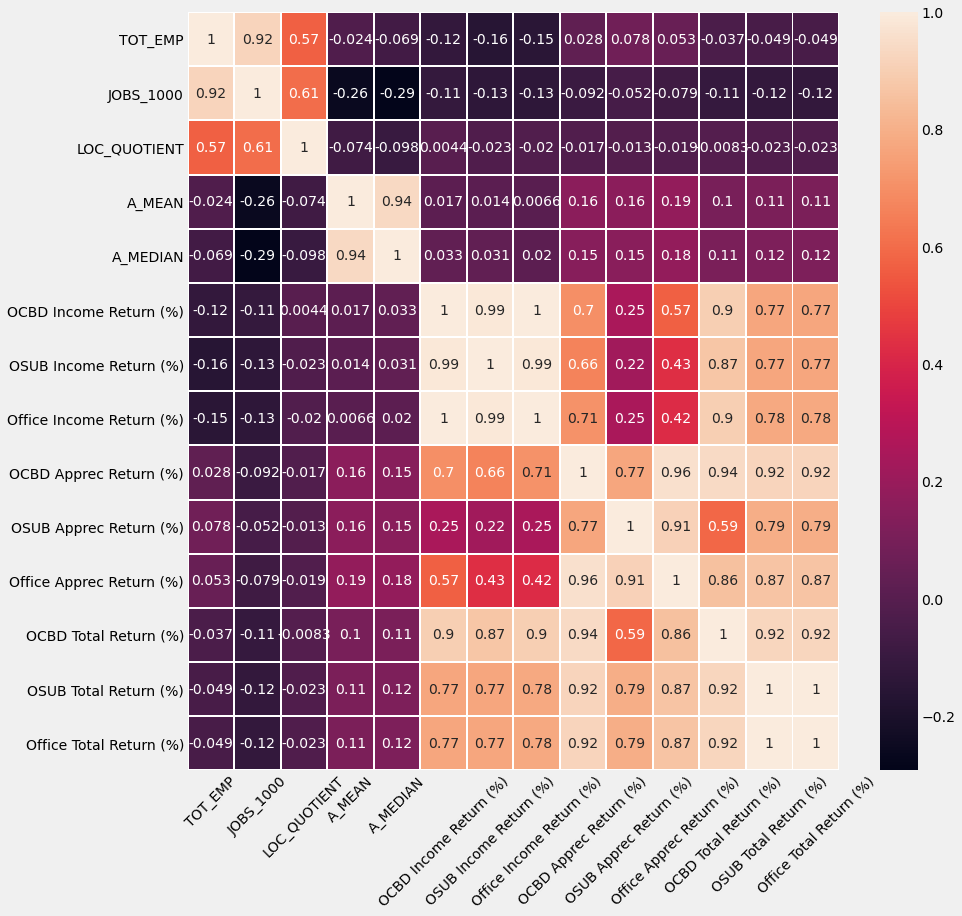

In [81]:
plt.subplots(figsize=(13,13))
corr_orig = sns.heatmap(Combined2.corr(), annot=True, fmt='.2g', linewidth=1)
plt.xticks(rotation=45)

### Examine Potential Linear Relationship
---
**Correlation:**

It appears that <u>A_MEAN</u> and <u>A_MEDIAN</u> exhibit the most significant positive correlations with the various office real estate returns; while <u>TOT_EMP</u> and <u>JOBS_1000</u> exhibit the most significant negative correlation. However, given the generally weak correlation between employment variables and real estate returns, further feature engineering is worth exploring. <br>
<br>
    
**Multicollinearity**: 
    
 - **Features**: <u>TOT_EMP</u>, <u>JOBS_1000</u> and <u>LOC_QUOTIENT</u> appear highly correlated with one another, expecially the former two. These variables respectively represent the 10-year annualized growth rate of number of total employment, number of employment per 1000 jobs and the ratio of an occupation’s share of employment in a given area to that occupation’s share of employment in the U.S. as a whole. In the modeling stage, I will take this into consideration when choosing feature variables. <br>
<br>    

 - **Output Variables** - Office Returns: As expected, the various types of Office returns are highly correlated with one another, especially between appreciation, income and total return for each of the three office categories (Total Office, Suburban Office - OSUB, and CBD Office - OCBD). Therefore, the 9 variables will be 9 separate output variables in the modeling stage.
    
*Note that all variables in the heatmap above are 10-year annualized growth/return for occupation and office real estate respectively.